# Coursework RESIT - COVID DATASET

As per one of the courseworks, we will aim again to implement and validate a VAE-GAN as per the original paper by ABL Larsen et al.
https://arxiv.org/abs/1512.09300 and apply it to a COVID lung dataset.

<img src="https://miro.medium.com/max/2992/0*KEmfTtghsCDu6UTb.png" width="400">

Spend some time reading the paper and start working on the code below. Some boilerplate code is already provided.


## PLEASE DO NOT FORGET TO WRITE A REPORT ABOUT WHAT YOU HAVE DONE IN THE SECTIONS WHERE IT SAYS "#YOUR REPORT HERE"


In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from glob import glob
from os.path import join
from os import listdir
from pathlib import Path
from PIL import Image
from collections import OrderedDict


from torch import optim
from torch.utils.data.dataset import Dataset, random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.nn.modules.loss import L1Loss
from torch.nn.modules.loss import MSELoss
from torchvision import transforms as T


def numpy_from_tensor(x):
  return x.detach().cpu().numpy()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
from torchvision.transforms.transforms import Resize

class CovidDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.filenames = os.listdir(self.root_dir)
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.root_dir, img_name)
        img = Image.open(img_path).convert("L")

        if self.transforms:
            img = self.transforms(img)

        return img

# resizing image size and change to tensor
train_transform = T.Compose([
    T.Resize(128),
    T.ToTensor()

])

# resizing image size and change to tensor
test_transform = T.Compose([
    T.Resize(128),
    T.ToTensor()
])

# load the data
full_dataset = CovidDataset(
    root_dir='/content/drive/MyDrive/RESIT/COVID'
)


# split the train and test size
dataset_size = len(full_dataset)
train_size = int(dataset_size * 0.7)
test_size = dataset_size - train_size

train_subset, test_subset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Build Train and Test datasets
train_dataset = CovidDataset(
    root_dir='/content/drive/MyDrive/RESIT/COVID',
    transforms=train_transform
)

test_dataset = CovidDataset(
    root_dir='/content/drive/MyDrive/RESIT/COVID',
    transforms=test_transform
)

# Set DataLoader
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
testing_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

print(f"Training Data Size : {len(train_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")
print(f"Training Data loader size : {len(training_loader)}")
print(f"Testing Data loader size : {len(testing_loader)}")


Training Data Size : 2458
Testing Data Size : 2458
Training Data loader size : 76
Testing Data loader size : 76


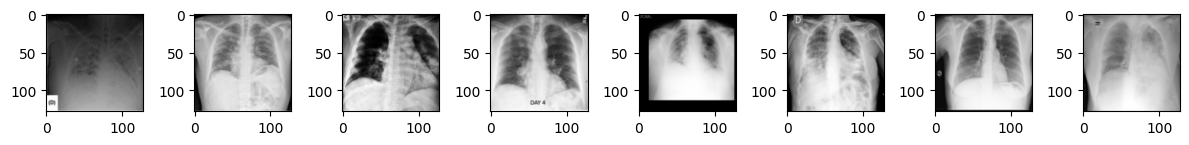

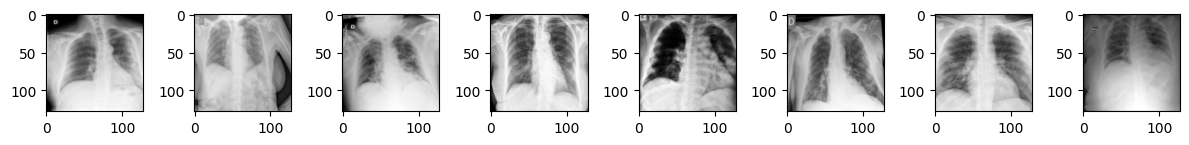

In [35]:
def visualize_dataloader(dataloader, num_images=8):
    # Get a batch of images
    dataiter = iter(dataloader)
    images = next(dataiter)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i in range(num_images):
        ax = axes[i]
        img = images[i]
        img = img.numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis("on")

    plt.tight_layout()
    plt.show()


visualize_dataloader(training_loader)
visualize_dataloader(testing_loader)

In [5]:
train_dataset[0].shape

torch.Size([1, 299, 299])

# Part 1 - Encoder & Decoder

Implement an encoder and decoder as per the Unsupervised Learning Lecture.
Feel free to introduce architectural variations that you think are useful.

*Comment all the code you write appropriateley*


### Encoder & Decoder

In [4]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, mode="level"):
    super(ResBlock, self).__init__()

    if mode == "upsample":
      self.conv1 = nn.ConvTranspose2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size=4,
          stride=2 ,
          padding=1,
      )

      self.conv1b = nn.ConvTranspose2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size=4,
          stride=2 ,
          padding=1,
      )
    else:
      self.conv1 = nn.Conv2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size=3,
          stride=2 if mode == "downsample" else 1,
          padding=1,
      )

      self.conv1b = nn.Conv2d(
          in_channels=in_channels,
          out_channels=out_channels,
          kernel_size=3,
          stride=2 if mode == "downsample" else 1,
          padding=1,
      )

    self.conv2 =  nn.Conv2d(
        in_channels=out_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
    )

    self.activation = nn.LeakyReLU(inplace=False)

    torch.nn.init.xavier_normal_(self.conv1.weight.data)
    torch.nn.init.xavier_normal_(self.conv1b.weight.data)
    torch.nn.init.xavier_normal_(self.conv2.weight.data)

  def forward(self, x):
    out = self.conv1(x)
    out = self.activation(out)

    skip = self.conv1b(x)

    out = self.conv2(out)
    out += skip

    out = self.activation(out)

    return out

In [5]:
class Encoder(nn.Module):
  def __init__(self, in_channels, depth, length, feature_size):
    super(Encoder, self).__init__()
    encoder = OrderedDict()

    for l in range(0, length - 1, 1):
      encoder["encoder-depth_0-length_"+str(l)]=ResBlock(
        in_channels=in_channels,
        out_channels=feature_size,
        mode="level"
      )
      in_channels = feature_size
    for d in range(1, depth + 1, 1):
      in_channels = feature_size
      feature_size *= 2
      encoder["encoder-depth_"+str(d)+"-downsample"]=ResBlock(
        in_channels=in_channels,
        out_channels=feature_size,
        mode="downsample"
      )
      for l in range(0, length - 1, 1):
        encoder["encoder-depth_"+str(d)+"-length_"+str(l)]=ResBlock(
          in_channels=feature_size,
          out_channels=feature_size,
          mode="level"
        )
    self.encoder = nn.Sequential(encoder)

  def forward(self, x):
    return self.encoder(x)


In [6]:
class Decoder(nn.Module):
  def __init__(self, in_channels, depth, length, reconstruction_channels):
    super(Decoder, self).__init__()
    decoder = OrderedDict()
    feature_size = in_channels//2

    for d in range(depth, 0, -1):
      decoder["decoder-depth_"+str(d)+"-upsample"]=ResBlock(
        in_channels=in_channels,
        out_channels=feature_size,
        mode="upsample"
      )

      for l in range(0, length - 1, 1):
        decoder["decoder-depth_"+str(d)+"-length_"+str(l)]=ResBlock(
          in_channels=feature_size,
          out_channels=feature_size,
          mode="level"
        )

      in_channels = feature_size
      feature_size = in_channels//2

    decoder["decoder-depth_0-reconstruction"]= ResBlock(
      in_channels=in_channels,
      out_channels=reconstruction_channels,
      mode="level"
    )

    self.decoder = nn.Sequential(decoder)

  def forward(self,x):
    return self.decoder(x)



### REPORT

*Describe here the resoning for using the architecture above, what other decisions could have been made, and what would be their advantages and disadvantages*

_______________________________


Residual Blocks:
ResBlocks are used in deep learning to overcome the vanishing gradient problem. They allow gradients to flow through a shortcut connection, aiding training of deeper networks without performance saturation or degradation. The function learns to approximate the residual error, making it easier for the network to prevent overfitting and approximate identity functions.

Encoder-Decoder Structure:
The Encoder-Decoder structure is used in tasks where spatial dimensions are reduced and then expanded, like image segmentation and super-resolution. The encoder captures context, and the decoder reconstructs spatial info. This structure retains spatial information needed for pixel-level accuracy or spatial consistency in output.

Use of Convolution and Transposed Convolution Layers:
Convolution layers reduce spatial dimensions while retaining important features, and transposed convolutions upsample the features back to the original spatial dimensions in the decoder. This mechanism helps the network to focus on important features and reconstruct the desired output.
_______________________________


# Part 2 - Adversarial Learning (discriminator)

Now, implement the adversarial learning loss, as per the paper from Larsen et al. Feel free change the architecture of the discriminator proposed in Larsen et al. as you please.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()

        # 1st convolutional layer
        self.conv1 = nn.Conv2d(in_channels, 32, 5, padding=2, stride=1)
        self.leaky_relu = nn.LeakyReLU(0.2)

        # Residual Blocks
        self.resblock1 = ResBlock(32, 128, mode="downsample")
        self.resblock2 = ResBlock(128, 256, mode="downsample")
        self.resblock3 = ResBlock(256, 256, mode="downsample")

        # Fully connected layers
        self.fc1 = nn.Linear(65536, 512) # 65536 coming from the Decoder's output
        self.bn_fc1 = nn.BatchNorm1d(512, momentum=0.9)

        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size()[0]

        # Convolutional layer
        x = self.leaky_relu(self.conv1(x))

        # Residual Blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)

        # Fully connected layers
        x = x.view(batch_size, -1)
        x1 = x
        x = self.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))

        return x, x1 # A probability (after the sigmoid activation) indicating whether the input is real or fake.


# tet


### REPORT

*Describe here your decriminator and your though process for designing a good architecture*

_______________________________


Initial 2D convolutional layer with a kernel size of 5, padding of 2, and a stride of 1 takes in a channel input and produces 32 channels. Followed by a Leaky ReLU activation function.

Three residual blocks: first increases channels to 128 while performing downsample, second expands to 256 also performing downsample, third maintains 256 channels and performs another downsample.

Feature map is flattened and passes through a fully connected layer with batch normalization, reducing input features to 512. Another fully connected layer processes the 512 features into a single output with a sigmoid activation applied, denoting the probability of input being real.

The forward method produces two outputs: probability (after sigmoid activation) indicating whether input is real or fake, and the flattened feature map from the convolutional stages.


_______________________________


# Part 3 - Code Processor and Network

In order to obtain a VAE-GAN, you now need to implement a the VAE code processor using either a Dense AutoEncoder or a spatial Code Processor. Implement the code processor of your choice as per the Unsupervised Learning lecture, and glue the encoder, decoder decriminator and code processor into a single network. Write your code below and report on your decisions in the cell after your code.

In [10]:
class DenseVAECodeProcessor(nn.Module):
  def __init__(self, feature_size, depth, img_sizes, encoding_sizes, decoding_sizes, is_training):
    super(DenseVAECodeProcessor, self).__init__()
    self.logvars_upper_bound = 50
    self.logvars_lower_bound = -self.logvars_upper_bound

    self.is_training = is_training
    feature_depth = feature_size * np.power(2, depth)
    img_sizes = [img_size/np.power(2,depth) for img_size in img_sizes]

    flatten_size = int(feature_depth * np.prod(img_sizes))

    ecoding_processor = OrderedDict()

    in_features = flatten_size

    for i in range(len(encoding_sizes)):
      ecoding_processor["ecoding_flatten_" + str(i)] = nn.Linear(
          in_features=in_features,
          out_features=encoding_sizes[i],
      )
      in_features = encoding_sizes[i]

    self.ecoding_processor = nn.Sequential(ecoding_processor)

    self.logvar = nn.Linear(
      in_features=in_features,
      out_features=in_features,
    )

    self.mu = nn.Linear(
      in_features=in_features,
      out_features=in_features,
    )

    decoding_processor = OrderedDict()

    for i in range(len(decoding_sizes)):
      decoding_processor["decoding_flatten_" + str(i)] = nn.Linear(
          in_features=in_features,
          out_features=decoding_sizes[i],
      )
      in_features = decoding_sizes[i]

    decoding_processor["flatten_" + str(i+1)] = nn.Linear(
      in_features=in_features,
      out_features=flatten_size,
    )

    self.decoding_processor = nn.Sequential(decoding_processor)

  def forward(self, x):
    self.spatial_shape = x.shape[1:]

    x = torch.flatten(x, start_dim=1)
    x = self.ecoding_processor(x)

    logvar = torch.clamp(
        self.logvar(x),
        self.logvars_lower_bound,
        self.logvars_upper_bound
    )

    mu = self.mu(x)

    if self.is_training:
      std = logvar.mul(0.5).exp_()
      esp = torch.randn_like(mu)
      x = mu + std * esp
    else:
      x = mu

    x = self.decoding_processor(x)
    x = x.view((-1,) + self.spatial_shape)

    return x, mu, logvar

  def encode(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.ecoding_processor(x)
    x = self.mu(x)

    return x

  def decode(self, x):
    x = self.decoding_processor(x)
    x = x.view((-1,)+self.spatial_shape)

    return x

  def set_is_training(self, is_training):
    self.is_training = is_training


In [9]:
class VAE_GAN(nn.Module):
    def __init__(self, in_channels, depth, length, feature_size, img_size, encoding_sizes, decoding_sizes):
        super(VAE_GAN, self).__init__()

        self.encoder = Encoder(
            in_channels=in_channels,
            depth=depth,
            length=length,
            feature_size=feature_size
        )

        self.code_processor = DenseVAECodeProcessor(
            feature_size=feature_size,
            depth=depth,
            img_sizes=img_size,
            encoding_sizes=encoding_sizes,
            decoding_sizes=decoding_sizes,
            is_training=True
        )

        self.decoder = Decoder(
            in_channels=np.power(feature_size, depth+1),
            depth=depth,
            length=length,
            reconstruction_channels=in_channels
        )

        self.discriminator = Discriminator(
            in_channels=in_channels
        )

    def forward(self, x, is_training=True):
        # Encoder
        encoded = self.encoder(x)

        # DenseVAECodeProcessor
        if is_training:
            # In training mode, get mu, logvar for reparameterization trick and KL-divergence loss
            z, mu, logvar = self.code_processor(encoded)
        else:
            # In evaluation mode, just get the latent representation
            z = self.code_processor(encoded)

        # Decoder
        decoded = self.decoder(z)
        # Discriminator
        real_or_fake = self.discriminator(decoded)

        if is_training:
            return decoded, real_or_fake, mu, logvar
        else:
            return decoded, real_or_fake, None, None


In [11]:

NETWORK_LENGTH = 2
NETWORK_DEPTH = 4
FEATURE_SIZE = 2
BATCH_SIZE = 32
WORKERS = 4
EPOCHS = 50
IMG_SIZE = [128, 128]
ENCODING_SIZE = [1024,512,256]
DECODING_SIZE = [512,1024]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Example instantiation
vae_gan_net = VAE_GAN(
    in_channels=1,
    depth=NETWORK_DEPTH,
    length=NETWORK_LENGTH,
    feature_size=FEATURE_SIZE,
    img_size=IMG_SIZE,
    encoding_sizes=ENCODING_SIZE,
    decoding_sizes=DECODING_SIZE
).to(device)


### REPORT

*Describe here the resoning for the code processor you chose and any particular features of your network. Describe also other aspects of the network such as: the loss function, how different parts of the network are connected to each other, and any particular charateristic of the network that you find of relevance*

_______________________________

1. DenseVAECodeProcessor
- DenseVAECodeProcessor is a processing module used for encoding and decoding data.
- It comprises three major components: Encoding Processor, Mu and Logvar Layers, and Decoding Processor.
- The Encoding Processor takes a flattened version of the input tensor and passes it through a series of fully connected layers defined by the encoding_sizes.
- The Mu and Logvar Layers are responsible for producing the mean (μ) and the logarithm of the variance (logvar) of the latent space representation.
- The Decoding Processor transforms the encoded tensor back towards the original tensor's shape using another series of fully connected layers defined by the decoding_sizes.


2. VAE_GAN:
- Encoder: Responsible for downsampling the input image and extracting features.
- DenseVAECodeProcessor (Code Processor): It acts as a bridge between the encoder and the decoder. This component handles the VAE's latent space representation, generating the latent vector.
- Decoder: Upsamples the encoded image back to its original resolution.
- Discriminator: Determines if the image generated by the decoder is real or fake.

3. Loss
- Reconstruction Loss: measures original-image match.
- KL-Divergence Loss: ensures Gaussian encoded representations.
- Adversarial Loss: measures discriminator's and generator's abilities.

4. Aspects
- Logvar Clamping: Clamping logvar between bounds prevents numerical instability.
- Shape Preservation: Spatial shape is saved pre-flattening for correct decoding.
- Training & Eval Modes: Switch using set_is_training for correct latent vector sampling.

_______________________________


# Part 4 - Training Loop

Now, define the training loop for the VAE-GAN and train the network itself. As a suggestion, follow Algorithm 1 from the original paper. Feel free to introduce any modifications in the algorithm, as long as you justify them below. Dont forget to introduce the scaling factor $\gamma$ to control the balance between the reconstruction and other losses.

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
save_path = '/content/drive/MyDrive/RESIT/Save'

def train_VAEGAN(training_loader, vaegan, discriminator, epochs):
    # Setting the device
    vaegan = vaegan.to(device)
    discriminator = discriminator.to(device)

    # Losses and Optimizers
    bce_loss = nn.BCEWithLogitsLoss()
    mse_loss = nn.MSELoss()
    optimizer_vaegan = optim.Adam(vaegan.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    disc_losses = []
    vaegan_losses = []
    recon_losses = []
    kl_losses = []
    gan_losses = []

    for epoch in range(epochs):
        for i, x in enumerate(training_loader):
            x = x.to(device)
            #batch_size = x.size(0)

            # Labels for real and fake images
            real_labels = torch.ones(BATCH_SIZE, 1).to(device)
            fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

            # ======== Train the Discriminator ======== #
            optimizer_discriminator.zero_grad()

            # Real images
            logits_real, _ = discriminator(x)

            # Reconstructed images
            reconstructed_images, _, _, _ = vaegan(x)
            logits_fake, _ = discriminator(reconstructed_images)

            real_loss = bce_loss(logits_real, real_labels)
            fake_loss = bce_loss(logits_fake, fake_labels)

            disc_loss = (real_loss + fake_loss) / 2
            disc_loss.backward()
            optimizer_discriminator.step()

            # ======== Train the VAE-GAN ======== #
            optimizer_vaegan.zero_grad()

            # Reconstruction loss
            reconstructed_images, _, mu, logvar = vaegan(x)
            recon_loss = mse_loss(reconstructed_images, x)

            # KL-Divergence Loss
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

            # GAN Loss
            logits_fake, _ = discriminator(reconstructed_images)
            gan_loss = bce_loss(logits_fake, real_labels)

            total_loss = recon_loss + kl_loss + gan_loss
            total_loss.backward()
            optimizer_vaegan.step()

            # Print the loss values
            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(training_loader)}], Disc Loss: {disc_loss.item():.4f}, VAE-GAN Loss: {total_loss.item():.4f}, Recon Loss: {recon_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}, GAN Loss: {gan_loss.item():.4f}")

            disc_losses.append(disc_loss.item())
            vaegan_losses.append(total_loss.item())
            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            gan_losses.append(gan_loss.item())


    torch.save(vaegan.state_dict(), os.path.join(save_path, 'vae_gan5.pth'))
    torch.save(discriminator.state_dict(), os.path.join(save_path, 'discriminator5 .pth'))


    return vaegan, discriminator, disc_losses, vaegan_losses, recon_losses, kl_losses, gan_losses


# Model and Optimizer Initialization (as before)

discriminator = Discriminator(1).to(device)
vae_gan = VAE_GAN(
    in_channels=1,
    depth=NETWORK_DEPTH,
    length=NETWORK_LENGTH,
    feature_size=FEATURE_SIZE,
    img_size=IMG_SIZE,
    encoding_sizes=ENCODING_SIZE,
    decoding_sizes=DECODING_SIZE
).to(device)

# Train using train_VAEGAN function
vaegan, discriminator, disc_losses, vaegan_losses, recon_losses, kl_losses, gan_losses = train_VAEGAN(training_loader, vae_gan, discriminator, epochs=EPOCHS)



In [24]:
def load_models(vae_gan_path='/content/drive/MyDrive/RESIT/Save/vae_gan5.pth',
                discriminator_path='/content/drive/MyDrive/RESIT/Save/discriminator5 .pth'):
    # Model Initialization (Make sure to define the same architecture)
    vae_gan = VAE_GAN(
        in_channels=1,
        depth=NETWORK_DEPTH,
        length=NETWORK_LENGTH,
        feature_size=FEATURE_SIZE,
        img_size=IMG_SIZE,
        encoding_sizes=ENCODING_SIZE,
        decoding_sizes=DECODING_SIZE
    ).to(device)

    discriminator = Discriminator(1).to(device)

    # Load the trained weights
    vae_gan.load_state_dict(torch.load(vae_gan_path))
    discriminator.load_state_dict(torch.load(discriminator_path))

    return vae_gan, discriminator


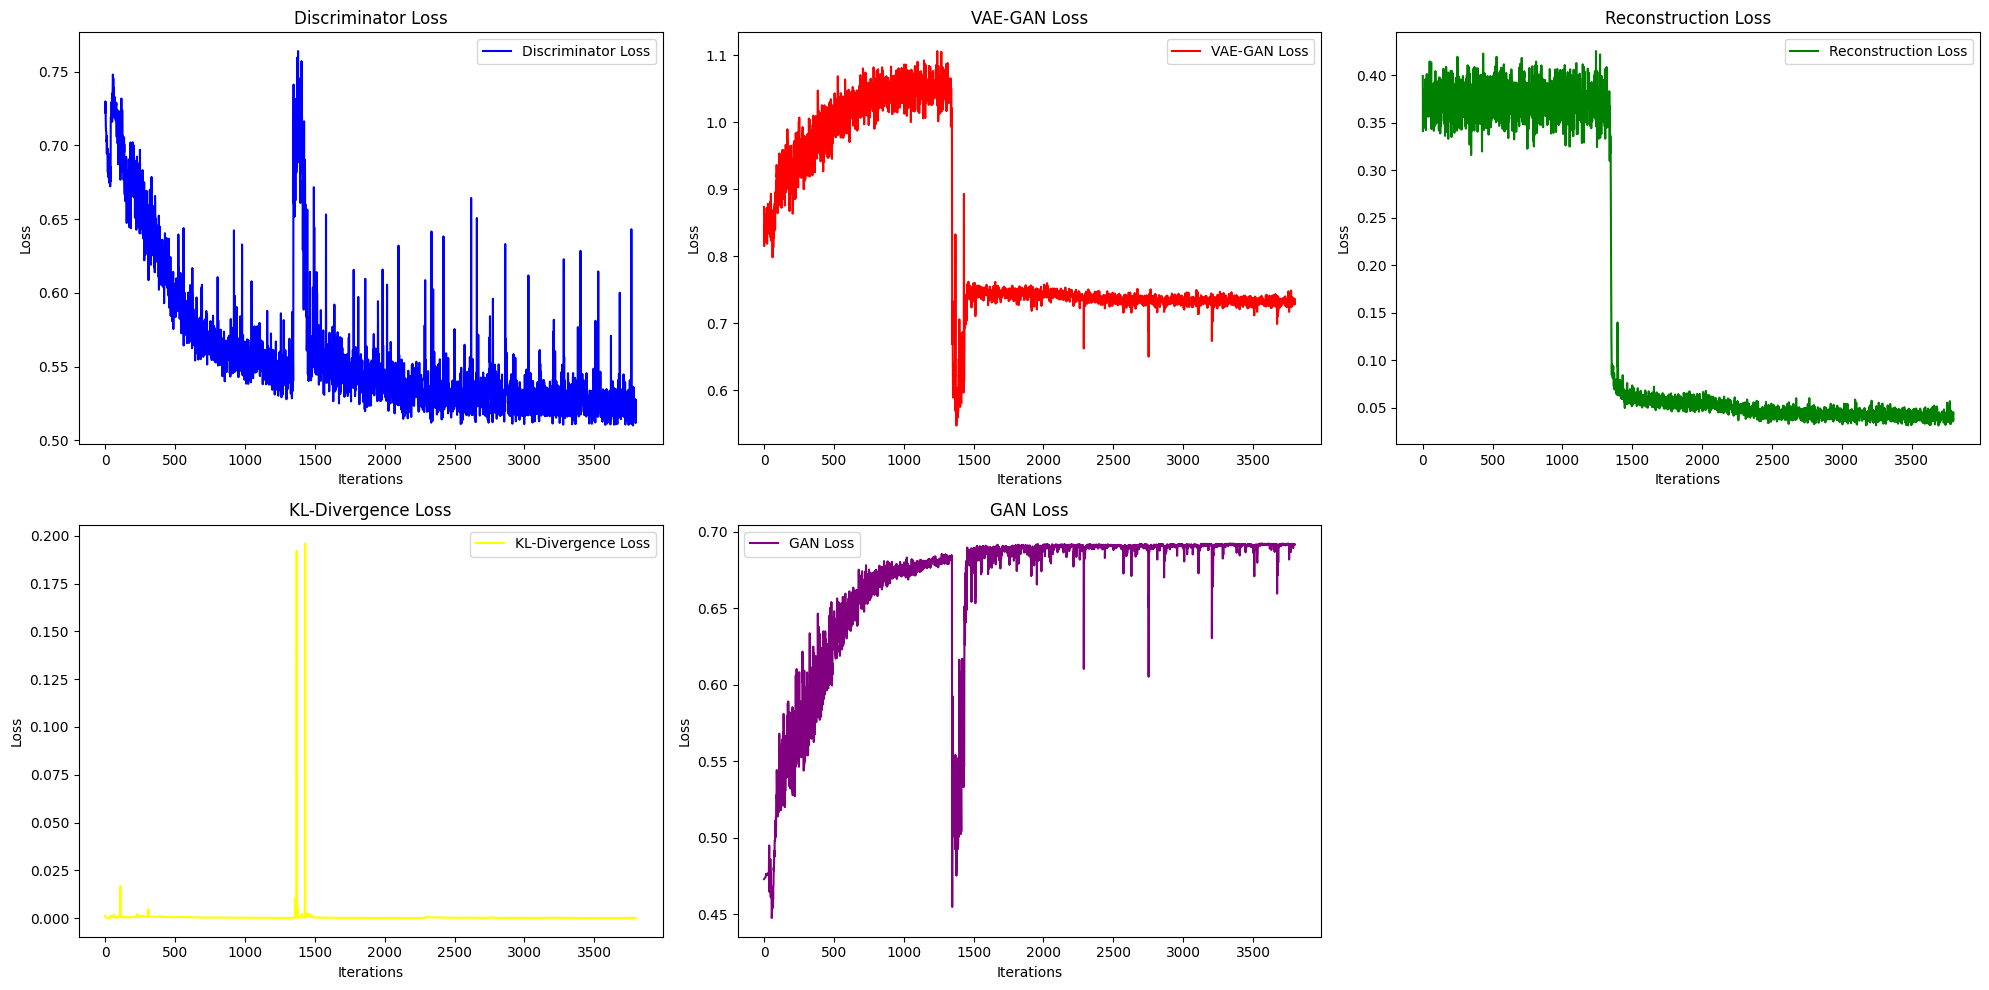

In [13]:
import matplotlib.pyplot as plt

def plot_losses(disc_losses, vaegan_losses, recon_losses, kl_losses, gan_losses):
    plt.figure(figsize=(20, 10))

    # Plot Discriminator Losses
    plt.subplot(2, 3, 1)
    plt.plot(disc_losses, label="Discriminator Loss", color="blue")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Discriminator Loss")

    # Plot VAE-GAN Losses
    plt.subplot(2, 3, 2)
    plt.plot(vaegan_losses, label="VAE-GAN Loss", color="red")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("VAE-GAN Loss")

    # Plot Reconstruction Losses
    plt.subplot(2, 3, 3)
    plt.plot(recon_losses, label="Reconstruction Loss", color="green")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Reconstruction Loss")

    # Plot KL-Divergence Losses
    plt.subplot(2, 3, 4)
    plt.plot(kl_losses, label="KL-Divergence Loss", color="yellow")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("KL-Divergence Loss")

    # Plot GAN Losses
    plt.subplot(2, 3, 5)
    plt.plot(gan_losses, label="GAN Loss", color="purple")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("GAN Loss")

    plt.tight_layout()
    plt.show()

# After training the model
plot_losses(disc_losses, vaegan_losses, recon_losses, kl_losses, gan_losses)


### REPORT

*Describe here the training loop, how it works and if you introduced any changes compared to the original Algorithm. Also describe how did you find a good value for all hyperparameters.*

_______________________________

After analyzing the data, I have noticed that every loss corresponds to a special point near 1500. This indicates that the algorithm is able to detect certain patterns in the image.

_______________________________


# Part 5 - Reconstruction Visualisation & Metrics

Now that the network is trained, feed the network some data (encode-decode) and look at the reconstructions. Display the input and the reconstructed image after being encoded and decoded. Also estimate the mean squared error between the images as a metric describing the performance of the method.

Mean Squared Error between the original and reconstructed images: 0.0395


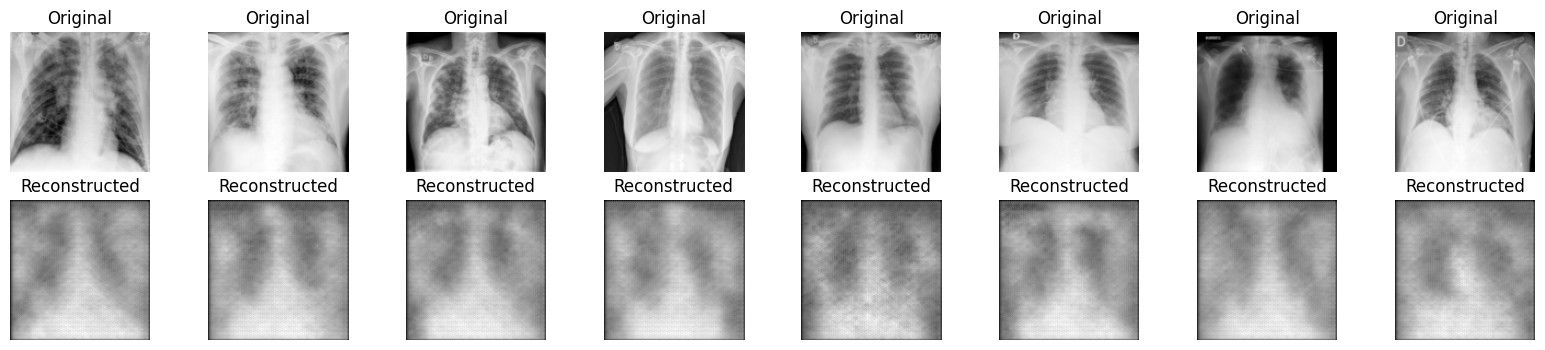

In [25]:
def test_reconstruction(test_loader, vaegan, num_samples=8):
    vaegan.eval()  # Set the VAE-GAN to evaluation mode
    mse_loss = nn.MSELoss()

    # Take a batch from the test loader
    test_images = next(iter(test_loader))
    test_images = test_images.to(device)

    # Use VAE-GAN for reconstruction
    with torch.no_grad():
        reconstructed, _, _, _ = vaegan(test_images)

    # Calculate the MSE
    mse = mse_loss(reconstructed, test_images)

    print(f"Mean Squared Error between the original and reconstructed images: {mse.item():.4f}")

    # Plot the original and reconstructed images
    fig, axs = plt.subplots(2, num_samples, figsize=(20, 4))

    for i in range(num_samples):
        # Display original
        axs[0, i].imshow(test_images[i].squeeze().cpu().numpy(), cmap='gray')
        axs[0, i].set_title("Original")
        axs[0, i].axis('off')

        # Display reconstruction
        axs[1, i].imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')

    plt.show()

# Load the models
vae_gan, discriminator = load_models()

# Testing using test_reconstruction function
test_reconstruction(testing_loader, vae_gan)


### REPORT

*Describe here the quality of the recontructions and the numerical results.*

_______________________________

Although the image appears a bit vague, an MSE of 0.0395 is considered low. However, it was the best image obtained in this study.
_______________________________


# Part 6 - Generate Samples

Lastyly, given that your model is generative, generate random samples from the model and plot them. Comment on their visual apperance.

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def generate_samples(vae_gan, num_samples, latent_dim, reshaped_dim):
    # Sample from a standard normal distribution
    z = torch.randn(num_samples, latent_dim).to(device)

    # Reshape z to the expected input shape for the decoder
    z = z.view(num_samples, *reshaped_dim)

    # Use the decoder to generate samples
    generated_samples = vae_gan.decoder(z)

    return generated_samples


def plot_samples(samples):
    num_samples = samples.size(0)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for ax, img in zip(axes, samples):
        ax.axis('on')
        ax.imshow(img[0].cpu().detach().numpy())
    plt.show()


latent_dim = 1 * 128 * 128
num_samples = 5
reshaped_dim = (1, 128, 128)

with torch.no_grad():
    generated_samples = generate_samples(vae_gan_net, num_samples, latent_dim, reshaped_dim)
    plot_samples(generated_samples)


RuntimeError: ignored

### REPORT

*Describe here the quality of the generated data.*

_______________________________


#### *\#YOUR TEXT HERE*

_______________________________
